# Detectron2 Inspect, Training and Inference

## Hot reloading

In [1]:
%load_ext autoreload
%autoreload 2

## Setup detectron2

In [1]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import os
import sys
import random
import time as time
import torch as torch
import torchvision as tv
import matplotlib.pyplot as plt


# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.data import DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

%matplotlib inline

ROOT_DIR = os.path.abspath("../")
sys.path.append(ROOT_DIR)
# im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB) # Alternative way of converting image from BGR to RGB
# im = cv2.imread("../input1.jpg")[:,:,::-1]
# plt.imshow(im)
# plt.show()
# cv2.imshow('image', im)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

## Check GPU availability

In [3]:
print("Number of GPUs: %s" % torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
print("GPU available: %s" % torch.cuda.is_available())


Number of GPUs: 1
GeForce RTX 2060
GPU available: True


## Load training and validation dataset

In [2]:
# Register training dataset
train_coco_json = "F:\\downloads\\train\\train\\annos_coco\\training_coco.json"
NAME_OF_DATASET_TRAIN = "deepfashion2_train"
IMAGE_DIR_TRAIN = "F:\\downloads\\train\\train\image"
NUMBER_OF_SAMPLES_TRAIN = 10000
# I think it's okay to use register_coco_instances, instead of load_coco_json, because 
# it uses load_coco_json itself anyways + registers metadata with metadatacatalog_get().set()
register_coco_instances(NAME_OF_DATASET_TRAIN, {}, train_coco_json, IMAGE_DIR_TRAIN, NUMBER_OF_SAMPLES_TRAIN)
# Load train dataset
tic = time.time()
dataset_train_dicts = DatasetCatalog.get(NAME_OF_DATASET_TRAIN)
cloth_train_metadata = MetadataCatalog.get(NAME_OF_DATASET_TRAIN)
print('Done (t={:0.2f}s)'.format(time.time() - tic))
print("Number of train data: %s" % len(dataset_train_dicts))

[11/11 07:27:42 d2.data.datasets.coco]: Loading F:\downloads\train\train\annos_coco\training_coco.json takes 243.42 seconds.
[11/11 07:27:42 d2.data.datasets.coco]: ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135

In [3]:
# Register validation dataset
val_coco_json = "F:\\Downloads\\validation\\validation\\annos_coco\\validation_coco.json"
NAME_OF_DATASET_VAL = "deepfashion2_val"
IMAGE_DIR_VAL = "F:\\Downloads\\validation\\validation\\image"
NUMBER_OF_SAMPLES_VAL = 3000
register_coco_instances(NAME_OF_DATASET_VAL, {}, val_coco_json, IMAGE_DIR_VAL, NUMBER_OF_SAMPLES_VAL)
# Load validation dataset
tic = time.time()
dataset_val_dicts = DatasetCatalog.get(NAME_OF_DATASET_VAL)
cloth_val_metadata = MetadataCatalog.get(NAME_OF_DATASET_VAL)
print('Done (t={:0.2f}s)'.format(time.time() - tic))
print("Number of validation data: %s" % len(dataset_val_dicts))

[11/11 07:33:23 d2.data.datasets.coco]: Loading F:\Downloads\validation\validation\annos_coco\validation_coco.json takes 17.00 seconds.
[11/11 07:33:23 d2.data.datasets.coco]: ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', 

## Display dataset images

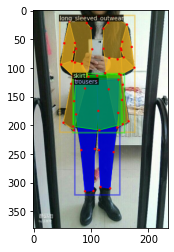

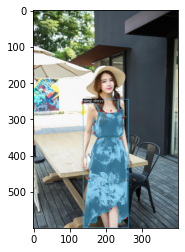

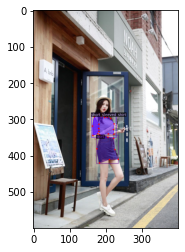

In [6]:
for d in random.sample(dataset_train_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=cloth_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()) # I think get_image returns the image again in BGR and I have to convert to RBG
    plt.show()

## Training on image segmentation

In [7]:
# Setup model configuration
cfg_seg = get_cfg()
cfg_seg.merge_from_file("../configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg_seg.DATASETS.TRAIN = (NAME_OF_DATASET_TRAIN,)
cfg_seg.DATASETS.TEST = ()   # no metrics implemented for this dataset
cfg_seg.DATALOADER.NUM_WORKERS = 2
cfg_seg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  # initialize from model zoo
cfg_seg.SOLVER.BASE_LR = 0.00025
cfg_seg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough, but you can certainly train longer
cfg_seg.SOLVER.IMS_PER_BATCH = 2
cfg_seg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset
cfg_seg.MODEL.ROI_HEADS.NUM_CLASSES = 13
cfg_seg.SOLVER.CHECKPOINT_PERIOD = 50

# Start training
tic = time.time()
os.makedirs(cfg_seg.OUTPUT_DIR, exist_ok=True)
trainer_seg = DefaultTrainer(cfg_seg) 
trainer_seg.resume_or_load(resume=False)
trainer_seg.train()
print('Done (t={:0.2f}s)'.format(time.time() - tic))

WARNING [11/11 00:00:52 d2.config.compat]: Config '../configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml' has no VERSION. Assuming it to be compatible with latest v2.
[11/11 00:00:57 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Co

'roi_heads.box_predictor.cls_score.weight' has shape (81, 1024) in the checkpoint but (14, 1024) in the model! Skipped.
'roi_heads.box_predictor.cls_score.bias' has shape (81,) in the checkpoint but (14,) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.weight' has shape (320, 1024) in the checkpoint but (52, 1024) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.bias' has shape (320,) in the checkpoint but (52,) in the model! Skipped.
'roi_heads.mask_head.predictor.weight' has shape (80, 256, 1, 1) in the checkpoint but (13, 256, 1, 1) in the model! Skipped.
'roi_heads.mask_head.predictor.bias' has shape (80,) in the checkpoint but (13,) in the model! Skipped.


### Inference of segmentation

In [9]:

# Setup predictor for inference
cfg_seg.MODEL.WEIGHTS = os.path.join(cfg_seg.OUTPUT_DIR, "model_final.pth")
cfg_seg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.08   # set the testing threshold for this model
cfg_seg.DATASETS.TEST = (NAME_OF_DATASET_VAL, )
predictor = DefaultPredictor(cfg_seg)

In [8]:
# dataset_val_dicts = DatasetCatalog.get(NAME_OF_DATASET_VAL)

[11/10 00:37:47 d2.data.datasets.coco]: Loading F:\Downloads\validation\validation\annos_coco\validation_coco.json takes 44.81 seconds.
[11/10 00:37:47 d2.data.datasets.coco]: Loaded 32153 images in COCO format from F:\Downloads\validation\validation\annos_coco\validation_coco.json


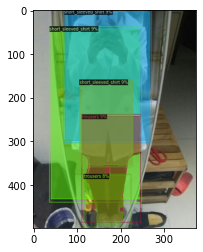

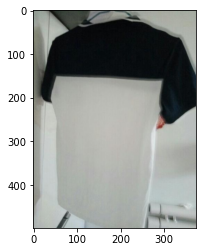

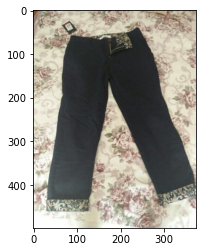

In [10]:
from detectron2.utils.visualizer import ColorMode
for d in random.sample(dataset_val_dicts, 3):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=cloth_val_metadata, 
                   scale=0.8, 
                   #instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(v.get_image())
    plt.show()

In [10]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output


Launching TensorBoard...

## Training on keypoints

In [4]:
# Setup model configuration
cfg_keypoint = get_cfg()
cfg_keypoint.merge_from_file("../configs/COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")
cfg_keypoint.DATASETS.TRAIN = (NAME_OF_DATASET_TRAIN,)
cfg_keypoint.DATASETS.TEST = ()   # no metrics implemented for this dataset
cfg_keypoint.DATALOADER.NUM_WORKERS = 2
cfg_keypoint.MODEL.WEIGHTS = "detectron2://COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x/137849621/model_final_a6e10b.pkl"  # initialize from model zoo
cfg_keypoint.SOLVER.BASE_LR = 0.00025
cfg_keypoint.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough, but you can certainly train longer
cfg_keypoint.SOLVER.IMS_PER_BATCH = 2
cfg_keypoint.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset
cfg_keypoint.MODEL.ROI_HEADS.NUM_CLASSES = 13
cfg_keypoint.MODEL.ROI_KEYPOINT_HEAD.NUM_KEYPOINTS = 294
cfg_keypoint.SOLVER.CHECKPOINT_PERIOD = 50

# Start training
tic = time.time()
os.makedirs(cfg_keypoint.OUTPUT_DIR, exist_ok=True)
trainer_keypoint = DefaultTrainer(cfg_keypoint) 
trainer_keypoint.resume_or_load(resume=False)
trainer_keypoint.train()
print('Done (t={:0.2f}s)'.format(time.time() - tic))

WARNING [11/11 07:34:09 d2.config.compat]: Config '../configs/COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml' has no VERSION. Assuming it to be compatible with latest v2.
[11/11 07:34:14 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
 

'roi_heads.box_predictor.cls_score.weight' has shape (2, 1024) in the checkpoint but (14, 1024) in the model! Skipped.
'roi_heads.box_predictor.cls_score.bias' has shape (2,) in the checkpoint but (14,) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.weight' has shape (4, 1024) in the checkpoint but (52, 1024) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.bias' has shape (4,) in the checkpoint but (52,) in the model! Skipped.
'roi_heads.keypoint_head.score_lowres.weight' has shape (512, 17, 4, 4) in the checkpoint but (512, 294, 4, 4) in the model! Skipped.
'roi_heads.keypoint_head.score_lowres.bias' has shape (17,) in the checkpoint but (294,) in the model! Skipped.


### Inference of keypoints

In [5]:
# Inference with a keypoint detection model
cfg_keypoint.MODEL.WEIGHTS = os.path.join(cfg_keypoint.OUTPUT_DIR, "model_final.pth")
cfg_keypoint.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.05   # set the testing threshold for this model
cfg_keypoint.DATASETS.TEST = (NAME_OF_DATASET_VAL, )
predictor = DefaultPredictor(cfg_keypoint)

In [6]:
for d in random.sample(dataset_val_dicts, 3):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=cloth_val_metadata, 
                   scale=1.2, 
                   #instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(v.get_image())
    plt.show()
    

RuntimeError: CUDA out of memory. Tried to allocate 574.00 MiB (GPU 0; 6.00 GiB total capacity; 3.31 GiB already allocated; 202.63 MiB free; 793.58 MiB cached)